## This code uses the metropolis algorithm to sample from the posterior distribution using the spring model as a simulator

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal, invgamma, gaussian_kde
from scipy.integrate import solve_ivp



In [2]:
def call_spring_model(q, IC, tspace):
    def spring_model_4par(t, y, params):
        C, K, F0, omegaF = params
        z = y[0]
        v = y[1]
        accel_eq = (-C * v - K * z) + F0 * np.cos(omegaF * t)
        return [v, accel_eq]

    sol = solve_ivp(spring_model_4par, [tspace[0], tspace[-1]], IC, t_eval=tspace, args=(q,))
    return sol.y[0]

In [3]:

def Metropolis_errupdate(f, data, prior_F, theta0, M, covar, UB, LB):
    """
    Implements the Metropolis algorithm with error variance updates using inverse gamma.

    Parameters:
    f: function - Model function.
    data: array - Observed data.
    prior_F: function - Prior probability distribution.
    theta0: array - Initial parameter values.
    M: int - Number of samples in the Markov chain.
    covar: array - Covariance matrix for proposal distribution.
    UB: array - Upper bounds for parameters.
    LB: array - Lower bounds for parameters.

    Returns:
    chain: array - Markov chain of sampled parameters.
    s2chain: array - Markov chain of error variance estimates.
    """

    n_par = len(theta0)
    chain = np.zeros((n_par, M))
    s2chain = np.zeros(M)
    n_y = len(data)

    if covar is None:
        covar = np.eye(n_par) * 0.1 * np.abs(theta0)

    # Functions for sum of squares and likelihood
    def ss_func(param, data):
        return np.sum((f(param) - data)**2)

    def lik_func(ss, s2):
        return np.exp(-ss / (2 * s2)) * (2 * np.pi * s2)**(-n_y / 2)

    chain[:, 0] = theta0
    ss_old = ss_func(theta0, data)
    sig_s = ss_old / (n_y - n_par)  # Estimate of error variance
    lik_old = lik_func(ss_old, sig_s)
    prior_old = prior_F(theta0)
    R = np.linalg.cholesky(covar)

    # Error variance hyperparameters for inverse gamma
    n_s = 0.01  # For inverse gamma
    aval = 0.5 * (n_s + n_y)  # This is constant
    bval = 0.5 * (n_s * sig_s + ss_old)
    s2chain[0] = invgamma.rvs(a=aval, scale=bval)

    num_acc = 0
    prob_acc = np.random.uniform(0, 1, M)

    for i in range(1, M):
        theta_star = chain[:, i - 1] + np.dot(R, np.random.normal(0, 1, n_par))

        # Check bounds
        if np.any(theta_star > UB) or np.any(theta_star < LB):
            ss_star = -np.inf
            lik_star = -np.inf
        else:
            ss_star = ss_func(theta_star, data)
            lik_star = lik_func(ss_star, s2chain[i - 1])
            lik_old = lik_func(ss_old, s2chain[i - 1])  # Recompute likelihood for comparison

        prior_star = prior_F(theta_star)
        acc_prob = (prior_star * lik_star) / (prior_old * lik_old)

        if acc_prob > prob_acc[i]:
            chain[:, i] = theta_star
            ss_old = ss_star
            lik_old = lik_star
            prior_old = prior_star
            num_acc += 1
        else:
            chain[:, i] = chain[:, i - 1]

        # Update sigma squared using inverse gamma
        bval = 0.5 * (n_s * sig_s + ss_old)
        s2chain[i] = invgamma.rvs(a=aval, scale=bval)

    print('Acceptance rate:', (num_acc / M) * 100)

    return chain, s2chain

In [5]:
# Compute the posterior distribution under the assumption of a uniform
# Initial conditions
z0 = 2
v0 = -2
IC = [z0, v0]

# The spring model has three parameters
C = 0.66       # damper friction, kg/s
K = 2          # spring resistance, kg/s^2
F0 = 1         # forcing term, kg cm / s^2
omegaF = 0.8   # frequency of forcing term, rad/s
noise_std = 0.15

# Put all the parameters together
param_star = [C, K, F0, omegaF]

tend = 20
tspace = np.linspace(0, tend, 30)
num_param = 4
n_xpts = len(tspace)


In [6]:
# Define priors
def prior_unif(param, a, b):
    return 1 / np.prod(b - a)



In [7]:
# Define model handle to pass around
f_mod = lambda q: call_spring_model(q, IC, tspace)
true_signal = f_mod(param_star)

# Things that can be adjusted
# Measurement noise
# noise_var = 0.01
noise_var = 0.05
# noise_var = 1.5

# MCMC algorithm parameters
M = 10000
theta0 = np.array(param_star) * 1.0

data = true_signal + np.random.normal(0, np.sqrt(noise_var), n_xpts)


In [8]:

# Sensitivity analysis for covariance estimation
S = np.zeros((n_xpts, num_param))
h = 1e-6
f_theta0 = f_mod(theta0)
for i in range(num_param):
    param_step = theta0.copy()
    param_step[i] += h
    S[:, i] = (f_mod(param_step) - f_theta0) / h

F = S.T @ S
s2_est = np.sum((data - f_mod(theta0))**2) / (n_xpts - num_param)

covar_est = s2_est * np.linalg.inv(F)

s_theta = 0.05 * np.ones(num_param)
covar_const = np.eye(num_param) * s_theta


In [9]:

# Construct the prior
UB = np.array([4, 4, 4, 4])  # Twenty percent above
LB = np.array([0.1, 0.1, 0.1, 0.1])  # Twenty percent below
prior_F = lambda param: prior_unif(param, LB, UB)


In [10]:
# Non sensitivity covar
chain_covar_const, s2_covar_const = Metropolis_errupdate(f_mod, data, prior_F, theta0, M, covar_const, UB, LB)

Acceptance rate: 1.71


In [11]:
# Sensitivity covar
chain_covar_est, s2_covar_est = Metropolis_errupdate(f_mod, data, prior_F, theta0, M, covar_est, UB, LB)

Acceptance rate: 41.870000000000005


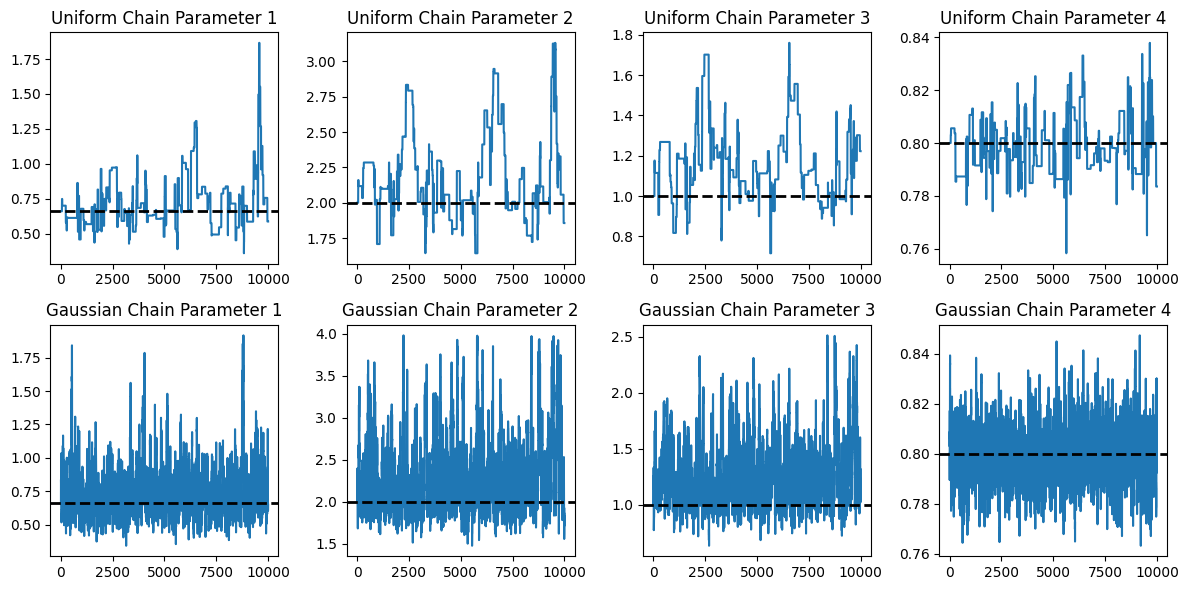

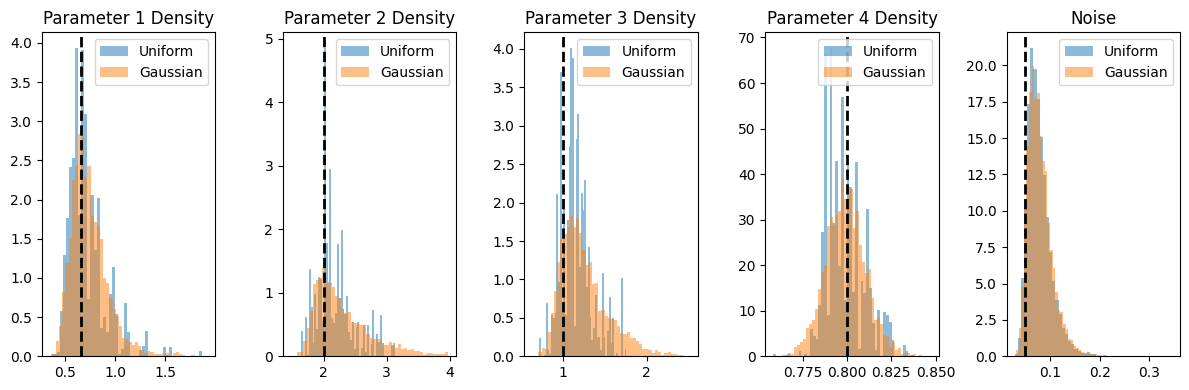

In [13]:

# Plot results
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(2, 4, i + 1)
    plt.plot(chain_covar_const[i, :])
    plt.axhline(param_star[i], color='k', linestyle='--', linewidth=2)
    plt.title(f'Uniform Chain Parameter {i+1}')
    
    plt.subplot(2, 4, i + 5)
    plt.plot(chain_covar_est[i, :])
    plt.axhline(param_star[i], color='k', linestyle='--', linewidth=2)
    plt.title(f'Gaussian Chain Parameter {i+1}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
for i in range(4):
    plt.subplot(1, 5, i + 1)
    plt.hist(chain_covar_const[i, :], bins=50, density=True, alpha=0.5, label="Uniform")
    plt.hist(chain_covar_est[i, :], bins=50, density=True, alpha=0.5, label="Gaussian")
    plt.axvline(param_star[i], color='k', linestyle='--', linewidth=2)
    plt.title(f'Parameter {i+1} Density')
    plt.legend()

plt.subplot(1, 5, 5)
plt.hist(s2_covar_const, bins=50, density=True, alpha=0.5, label="Uniform")
plt.hist(s2_covar_est, bins=50, density=True, alpha=0.5, label="Gaussian")
plt.axvline(noise_var, color='k', linestyle='--', linewidth=2)
plt.title('Noise')
plt.legend()
plt.tight_layout()
plt.show()

MAP - Const: [0.61316389 2.03167278 1.11035301 0.79208298]
MAP - Est: [0.66303232 1.98790303 1.13109607 0.79914976]
True Params: [0.66, 2, 1, 0.8]


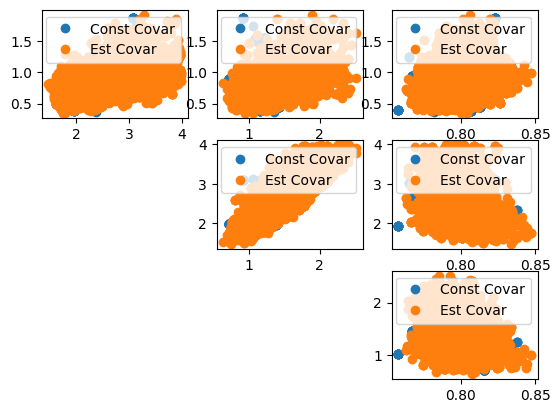

In [16]:
# Initialize variables
MAP_const = np.zeros(num_param)
MAP_est = np.zeros(num_param)

# Pairwise plot
plt.figure(5)
plt.clf()
for i in range(4):
    for j in range(i+1, 4):
        plt.subplot(3, 3, 3*(i)+j)
        plt.plot(chain_covar_const[j, :], chain_covar_const[i, :], 'o', label='Const Covar')
        plt.plot(chain_covar_est[j, :], chain_covar_est[i, :], 'o', label='Est Covar')
        plt.legend()

    # Get density values for constant covariance chain
    kde_const = gaussian_kde(chain_covar_const[i, :])
    x_const = np.linspace(min(chain_covar_const[i, :]), max(chain_covar_const[i, :]), 1000)
    f_const = kde_const(x_const)

    # Find the maximum of the PDF
    MAP_const[i] = x_const[np.argmax(f_const)]

    # Get density values for estimated covariance chain
    kde_est = gaussian_kde(chain_covar_est[i, :])
    x_est = np.linspace(min(chain_covar_est[i, :]), max(chain_covar_est[i, :]), 1000)
    f_est = kde_est(x_est)

    # Find the maximum of the PDF
    MAP_est[i] = x_est[np.argmax(f_est)]

# Display results
print("MAP - Const:", MAP_const)
print("MAP - Est:", MAP_est)
print("True Params:", param_star)




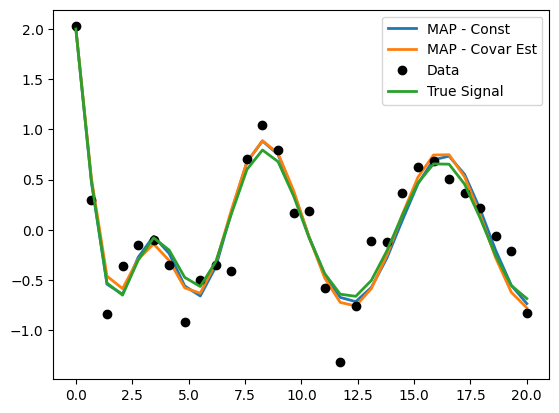

In [19]:
# Plot data against MAP estimates
plt.figure(10)
plt.clf()
plt.plot(tspace, f_mod(MAP_const), label="MAP - Const", linewidth=2)
plt.plot(tspace, f_mod(MAP_est), label="MAP - Covar Est", linewidth=2)
plt.plot(tspace, data, 'ko', label="Data")
plt.plot(tspace, true_signal, label="True Signal", linewidth=2)
plt.legend()
